# Binary Classification of Insurance Cross Selling

*Note: This notebook is part of the Kaggle Playground series (season 4, episode 7). You can find more details about the competition [at this link.](https://www.kaggle.com/competitions/playground-series-s4e7/data)*

This notebook represents an end-to-end analysis and model creation for cross selling of insurance products. This notebook is broken down into the following sections.

- **About the Competition**: This section will provide an intuitive overview of what this competition is seeking to accomplish.
- **Personal Motivations**: This section covers a few of my personal motivations for this particular competition and explains why I've made some of the choices that I have.
- **Notebook Setup**: We'll set ourselves up for success by doing things like importing the necessary Python libraries and also loading our data. This notebook will also be set up to work either directly in a Kaggle notebook or in a local environment.
- **Exploratory Data Analysis (EDA)**: As with any data science effort, this section will look to gain an understanding of the data we're working with by producing things like visualizations around each feature.
- **Feature Engineering**
- **Predictive Modeling**
- **Closing Thoughts**

## About the Competition

## Personal Motivations
This is the very first Kaggle competition I've ever participated in in earnest! I know, I know, it's not a true competition, but it seems like a good way to get my feet wet. I am a principal machine learning engineer at a Fortune 50 company, and at my company, it's more so the focus of the data scientist role to build the predictive model. My role as a machine learning engineer is more around successful deployment of these models, so while my role does require general data science knowledge, I am not particularly an expert modeler.

That said, my general motivation for participating in this competition is to grow in my predictive modeling skills. Specifically, you will note that I rely on **Polars** throughout this notebook. I have extensive knowledge with Pandas but am more of a novice when it comes to Polars. As such, I thought this would be a good opportunity to leverage Polars throughout this competition.

## Notebook Setup
This section will set up everything that we will use in the remainder of the notebook. One thing to specifically note: I have imported my custom visualization functions from outside this notebook. If you would like to see the code behind these visualization tools, check out this link: [Visualization Tools](https://www.kaggle.com/code/dkhundley/visualization-tools). Note: These visualization functions have been exclusively designed to work with Polars.

In [1]:
# Importing the necessary Python libraries
import os
import sys

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Importing our custom utilities
if 'KAGGLE_URL_BASE' in os.environ:
    from visualization_tools import *
else:
    import kaggle
    import zipfile
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'utilities')))
    from visualization_tools import *
    from data_utilities import download_and_extract_kaggle_data

In [2]:
# Downloading the Kaggle data to a local environment
if 'KAGGLE_URL_BASE' not in os.environ:
    competition_name = 'playground-series-s4e7'
    download_and_extract_kaggle_data(competition_name)

Data for playground-series-s4e7 already exists in 'data/' directory.


In [3]:
# Loading the datasets as Polars DataFrames
if 'KAGGLE_URL_BASE' in os.environ:
    df = pl.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
    df_test = pl.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
    df_sample_submission = pl.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
else:
    df = pl.read_csv('data/train.csv')
    df_test = pl.read_csv('data/test.csv')
    df_sample_submission = pl.read_csv('data/sample_submission.csv')

In [4]:
# Setting the visualization color theme
set_color_theme()

# Setting a boolean value to run the visualizations when desired
run_visualizations = True

## Exploratory Data Analysis (EDA)
Now that we've loaded up our data, let's move into exploratory data analysis (EDA). The competition itself doesn't give us a whole lot of information about each data feature, so here is what my approach is going to be:

1. Since there are only 12 features, I don't think it's unfeasible to look at all of them at an individual level. This will include visualizations.
2. If I am still a bit hazy on what the feature represents, I'll check out the Kaggle discussion board to see if anybody has any particular insight.

On completing step 1 above, I found trying to understand what several of these features to mean to be lacking. Combing the Kaggle discussion board, I found one user reference [this other Kaggle dataset](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) that provides a more thorough description of each feature.

### Holistic EDA
Before we do a deep dive on each individual feature, let's do a holistic EDA on the dataset at a high level.

In [5]:
# Displaying the column names of the Polars DataFrame
df.columns

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [6]:
# Viewing the holistic statistics of the Polars DataFrame
df.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""count""",1.1504798e7,"""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,"""11504798""","""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",5752398.5,null,38.383563,0.998022,26.41869,0.462997,null,null,30461.370411,112.425442,163.897744,0.122997
"""std""",3.3211e6,null,14.993459,0.044431,12.99159,0.498629,null,null,16454.745205,54.035708,79.979531,0.328434
"""min""",0.0,"""Female""",20.0,0.0,0.0,0.0,"""1-2 Year""","""No""",2630.0,1.0,10.0,0.0
"""25%""",2.876199e6,null,24.0,1.0,15.0,0.0,null,null,25277.0,29.0,99.0,0.0
"""50%""",5.752399e6,null,36.0,1.0,28.0,0.0,null,null,31824.0,151.0,166.0,0.0
"""75%""",8.628598e6,null,49.0,1.0,35.0,1.0,null,null,39451.0,152.0,232.0,0.0
"""max""",1.1504797e7,"""Male""",85.0,1.0,52.0,1.0,"""> 2 Years""","""Yes""",540165.0,163.0,299.0,1.0


### Feature 1: `id`
This one is pretty easy to deal with. It's simply a unique identifier for each row, so it does not offer any semantic value in trying to derive an inference. In simpler words, we can't do anything with it, so we'll end up getting rid of this feature before training the model.

**Feature Engineering Plans**:
- Drop the feature entirely

### Feature 2: `Gender`
As the name implies, this feature represents a person's gender. The feature manifests in a binary state, meaning that the only values found in this feature include `Male` and `Female`.

**Feature Engineering Plans**:
- Convert the `Gender` from its current string state into a one hot encoding

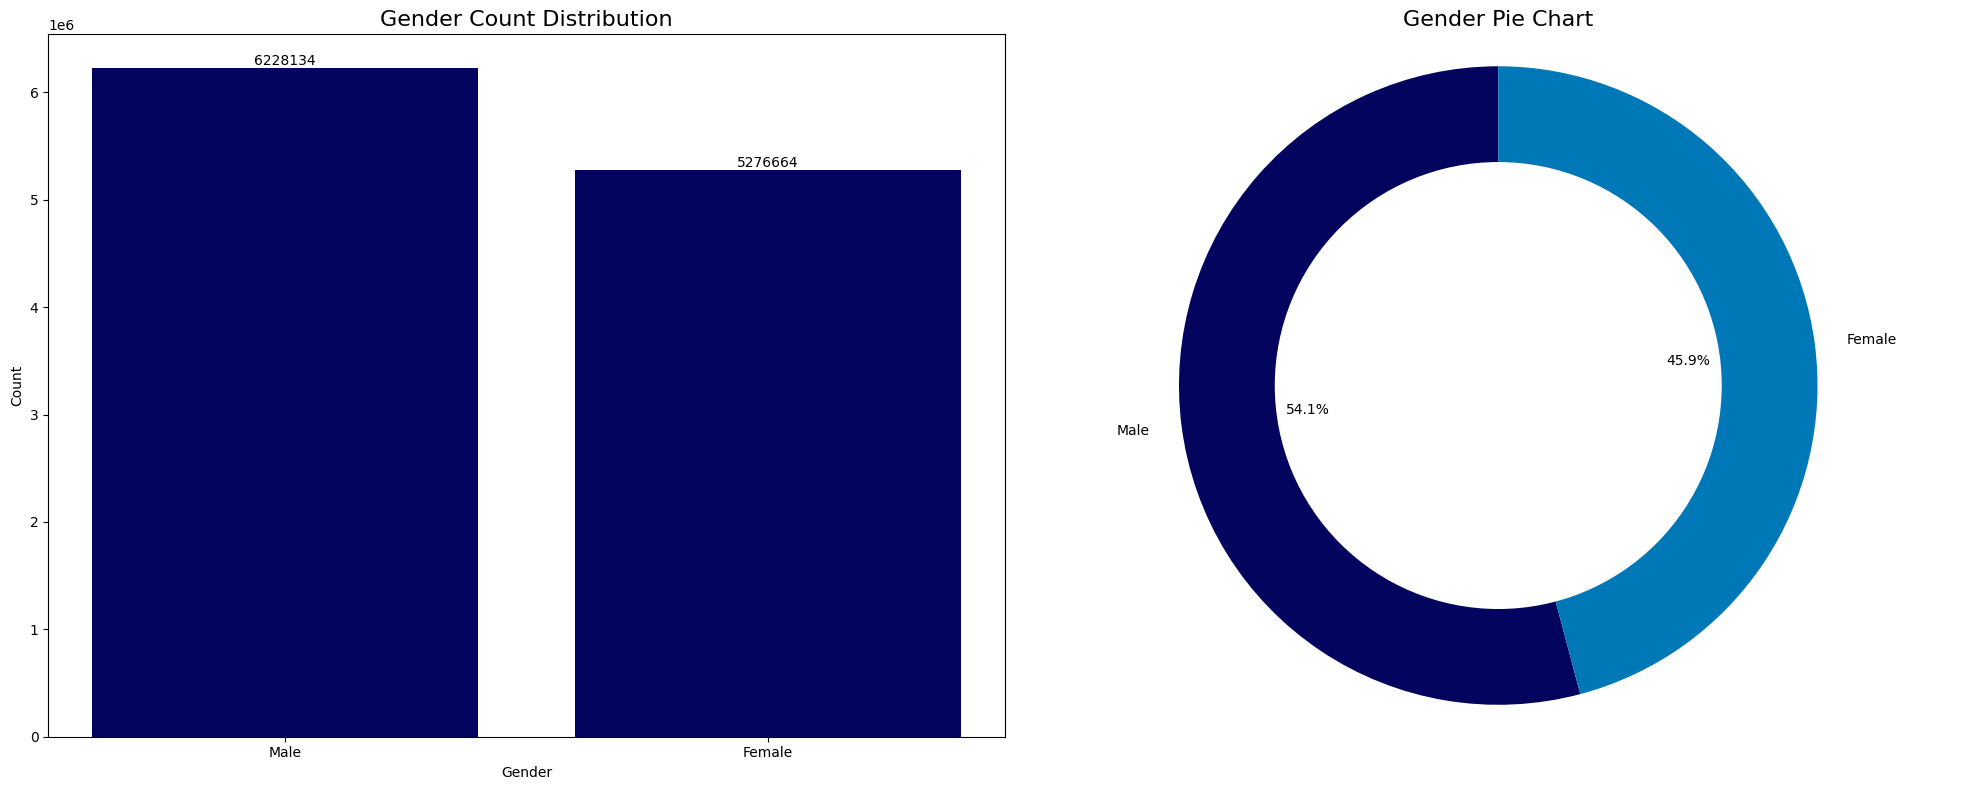

In [7]:
# Displaying general visualizations around the Gender feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Gender'])

### Feature 3: `Age`

**Feature Engineering Plans**:
- d

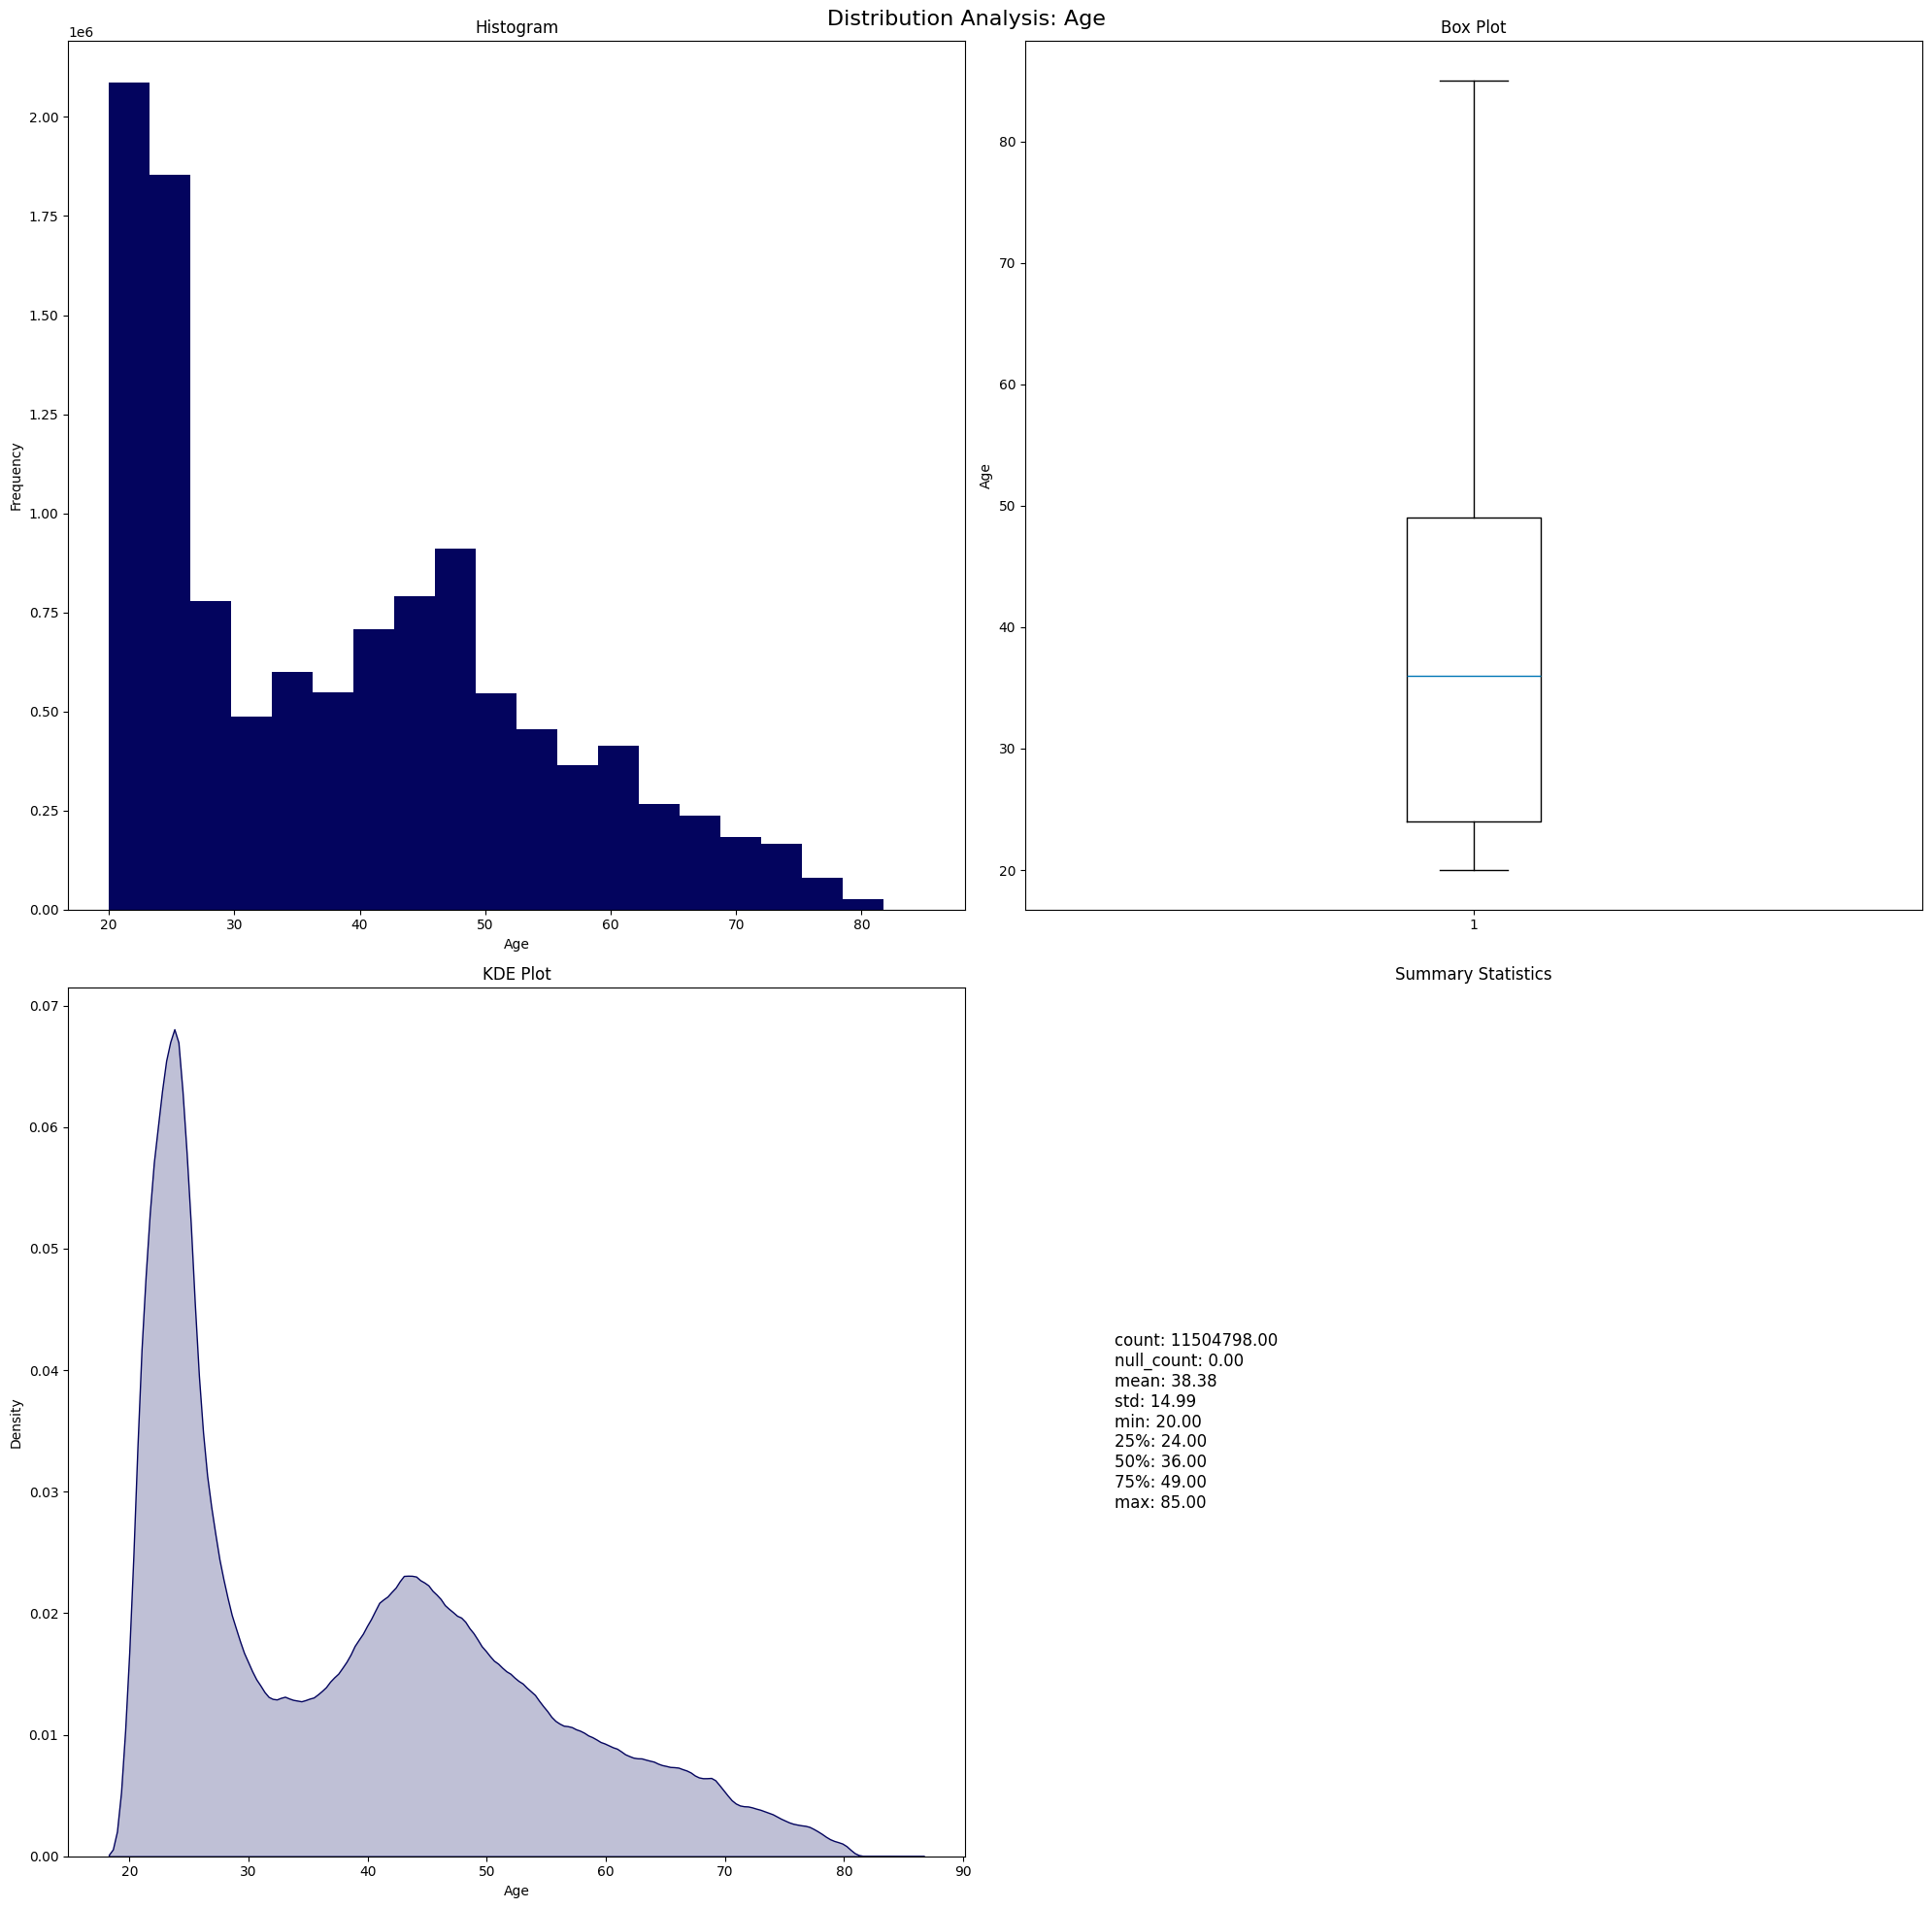

In [8]:
# Displaying general visualizations around the Age feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = df['Age'])

### Feature 4: `Driving_License`

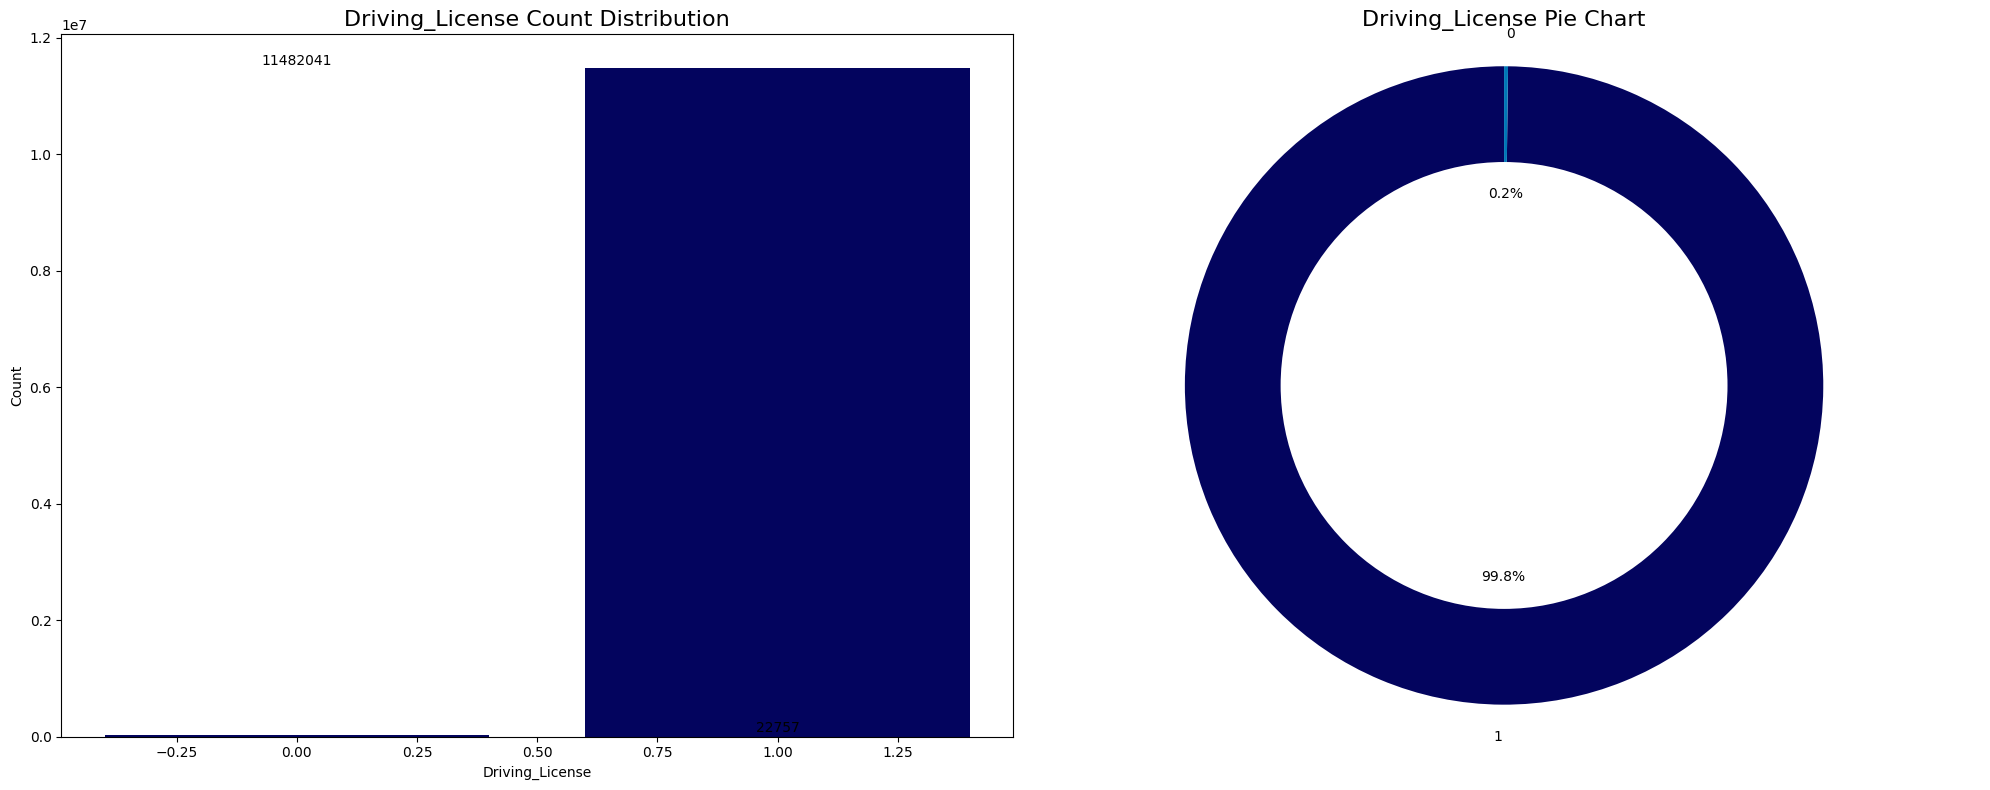

In [9]:
# Displaying general visualizations around the Driving_License feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Driving_License'])

### Feature 5: `Region_Code`

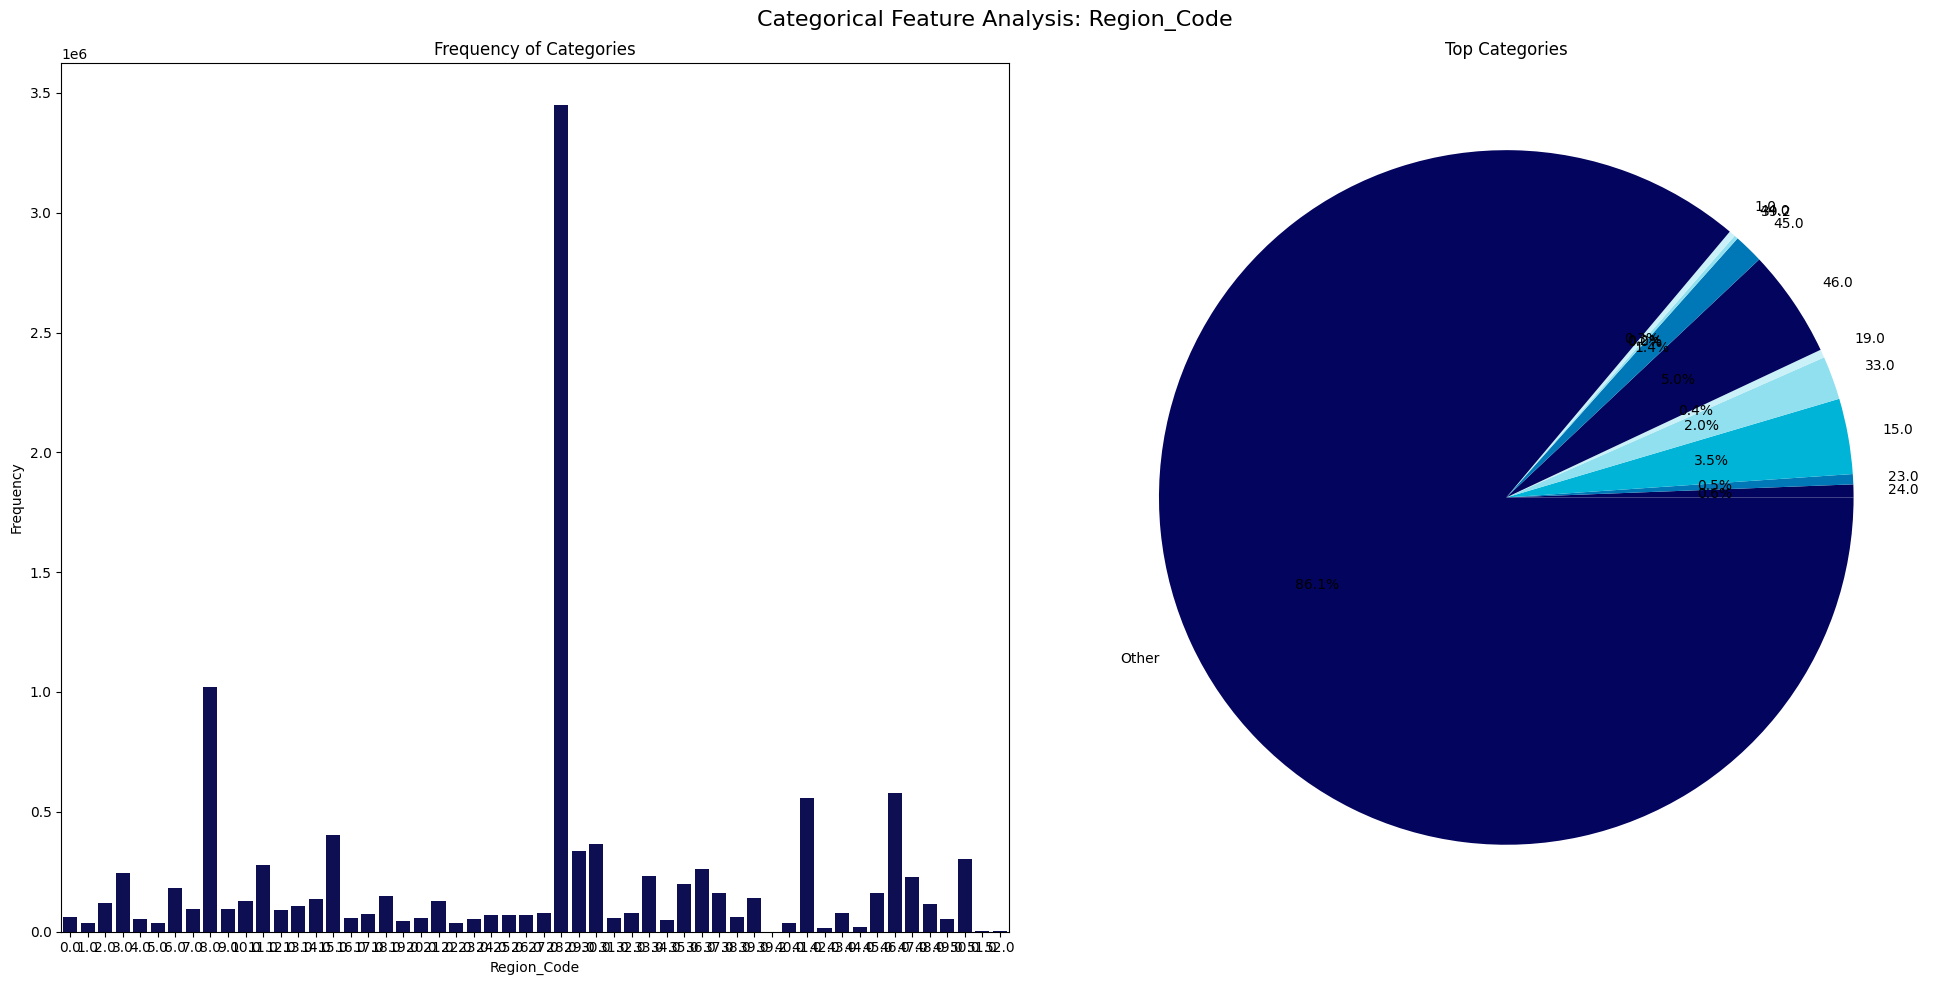

In [10]:
# Displaying general visualizations around the Region_Code feature
if run_visualizations:
    display_categorical_visualizations(cat_feat = df['Region_Code'])

### Feature 6: `Previously_Insured`

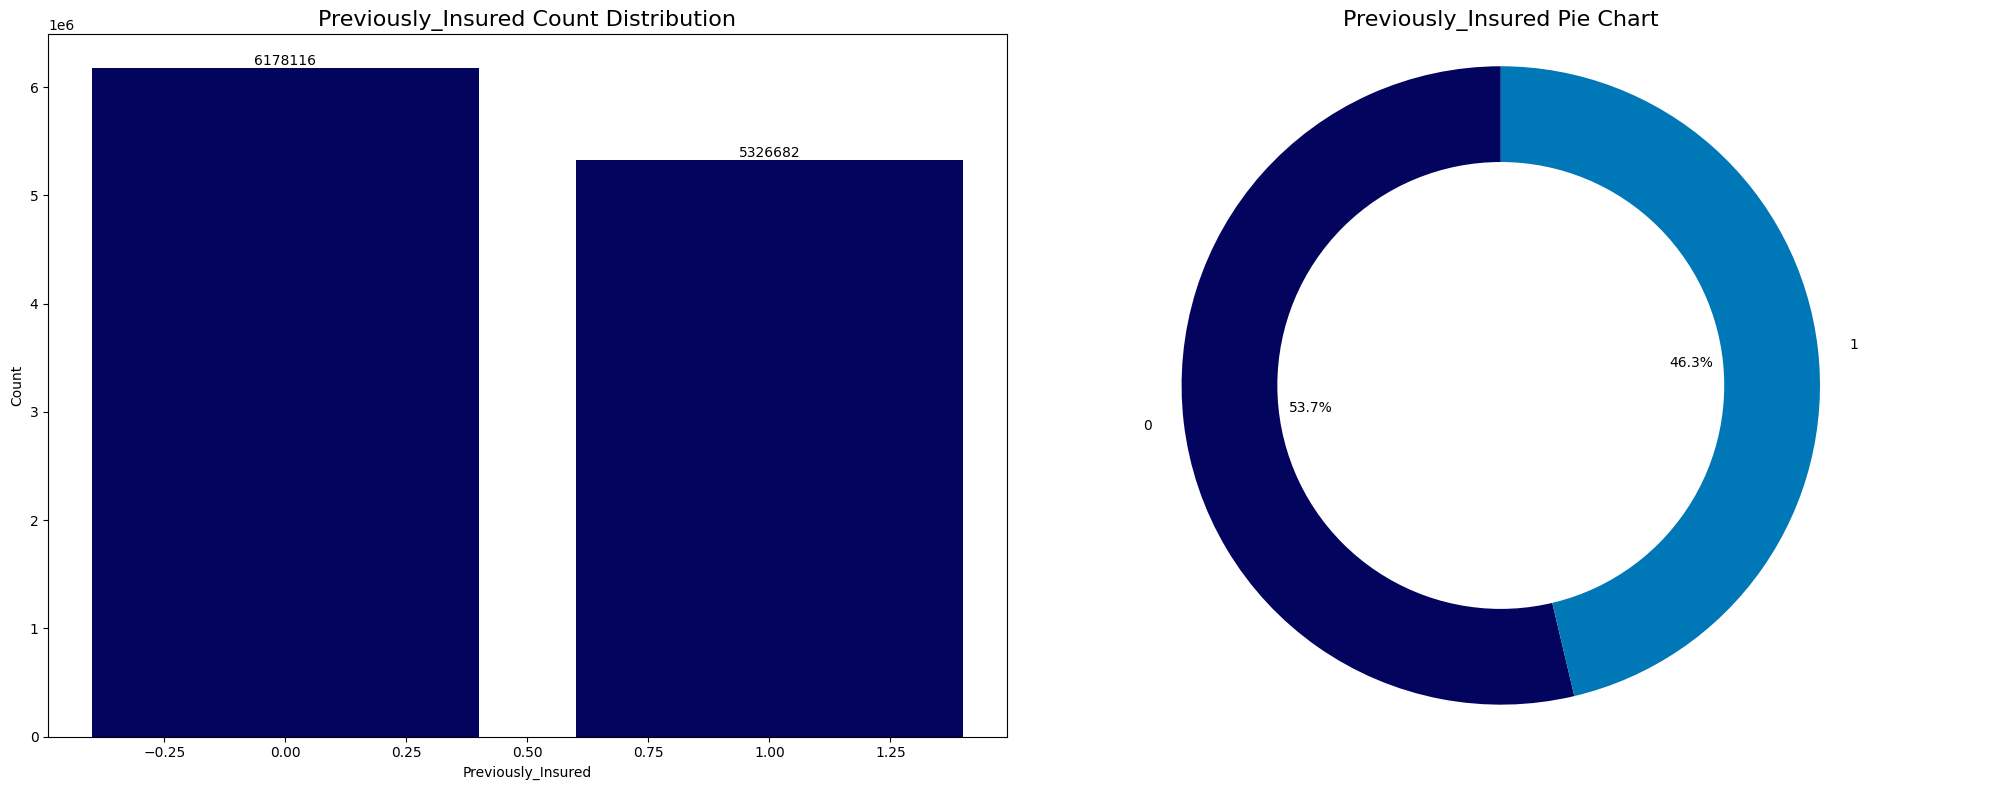

In [11]:
# Displaying general visualizations around the Previously_Insured feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Previously_Insured'])

### Feature 7: `Vehicle_Age`

In [12]:
# Displaying general visualizations around the Vehicle_Age feature
# if run_visualizations:
#     display_categorical_visualizations(cat_feat = df['Vehicle_Age'])

### Feature 8: `Vehicle_Damage`

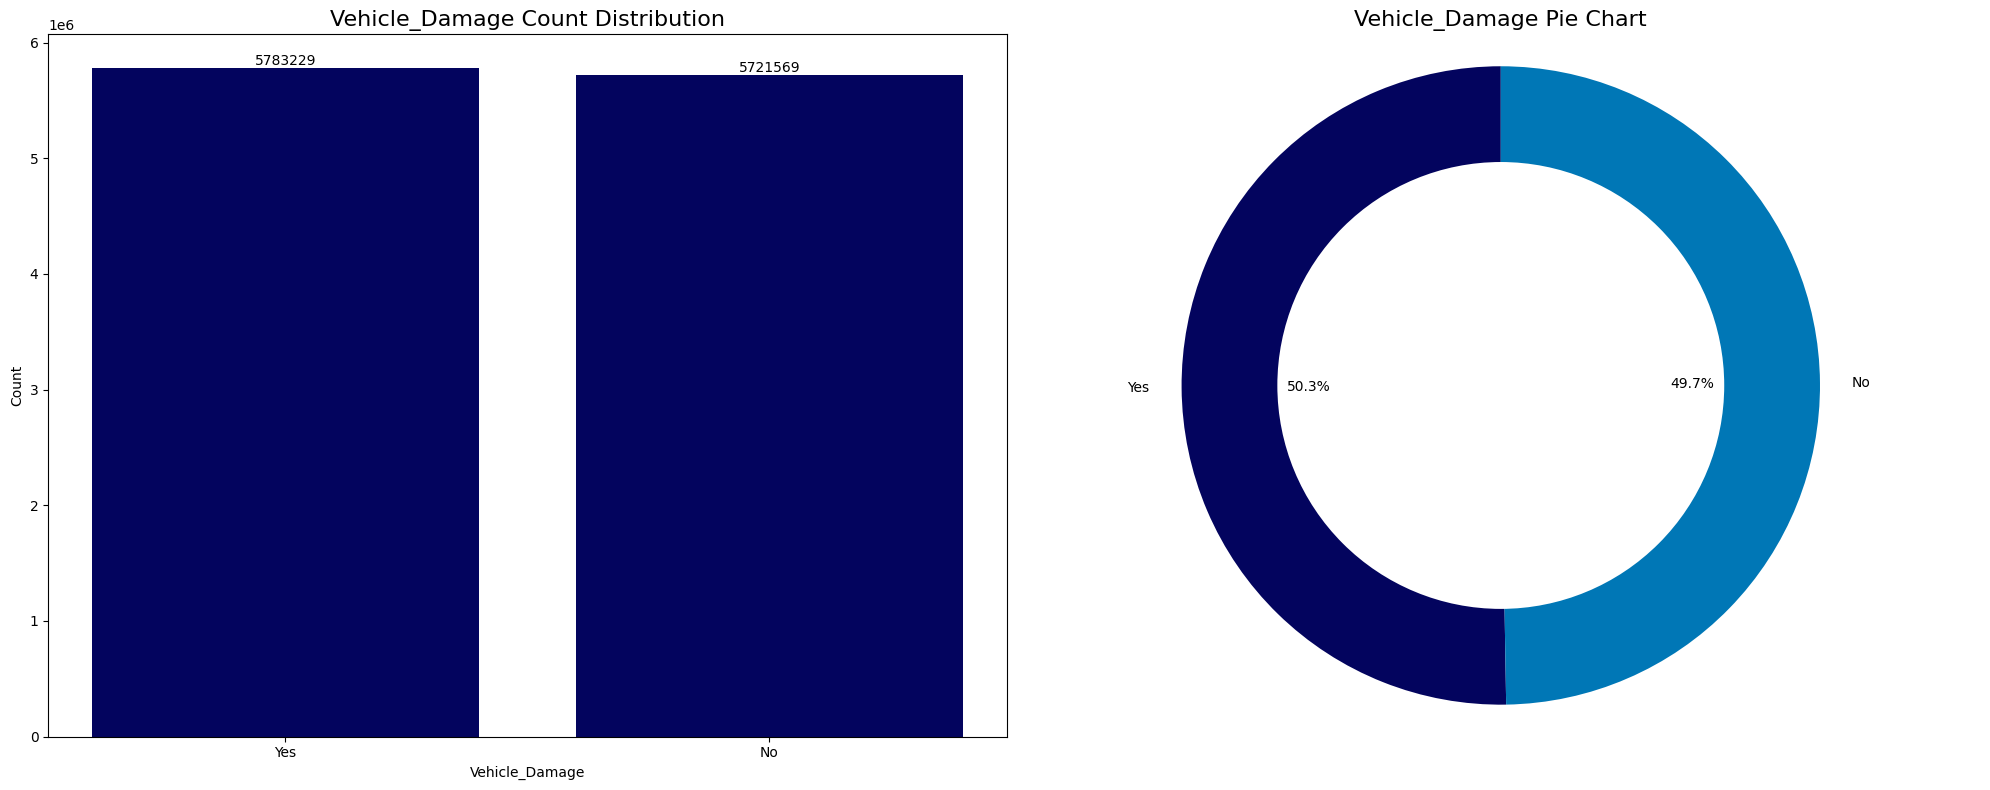

In [13]:
# Displaying general visualizations around the Vehicle_Damage feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Vehicle_Damage'])

### Feature 9: `Annual_Premium`

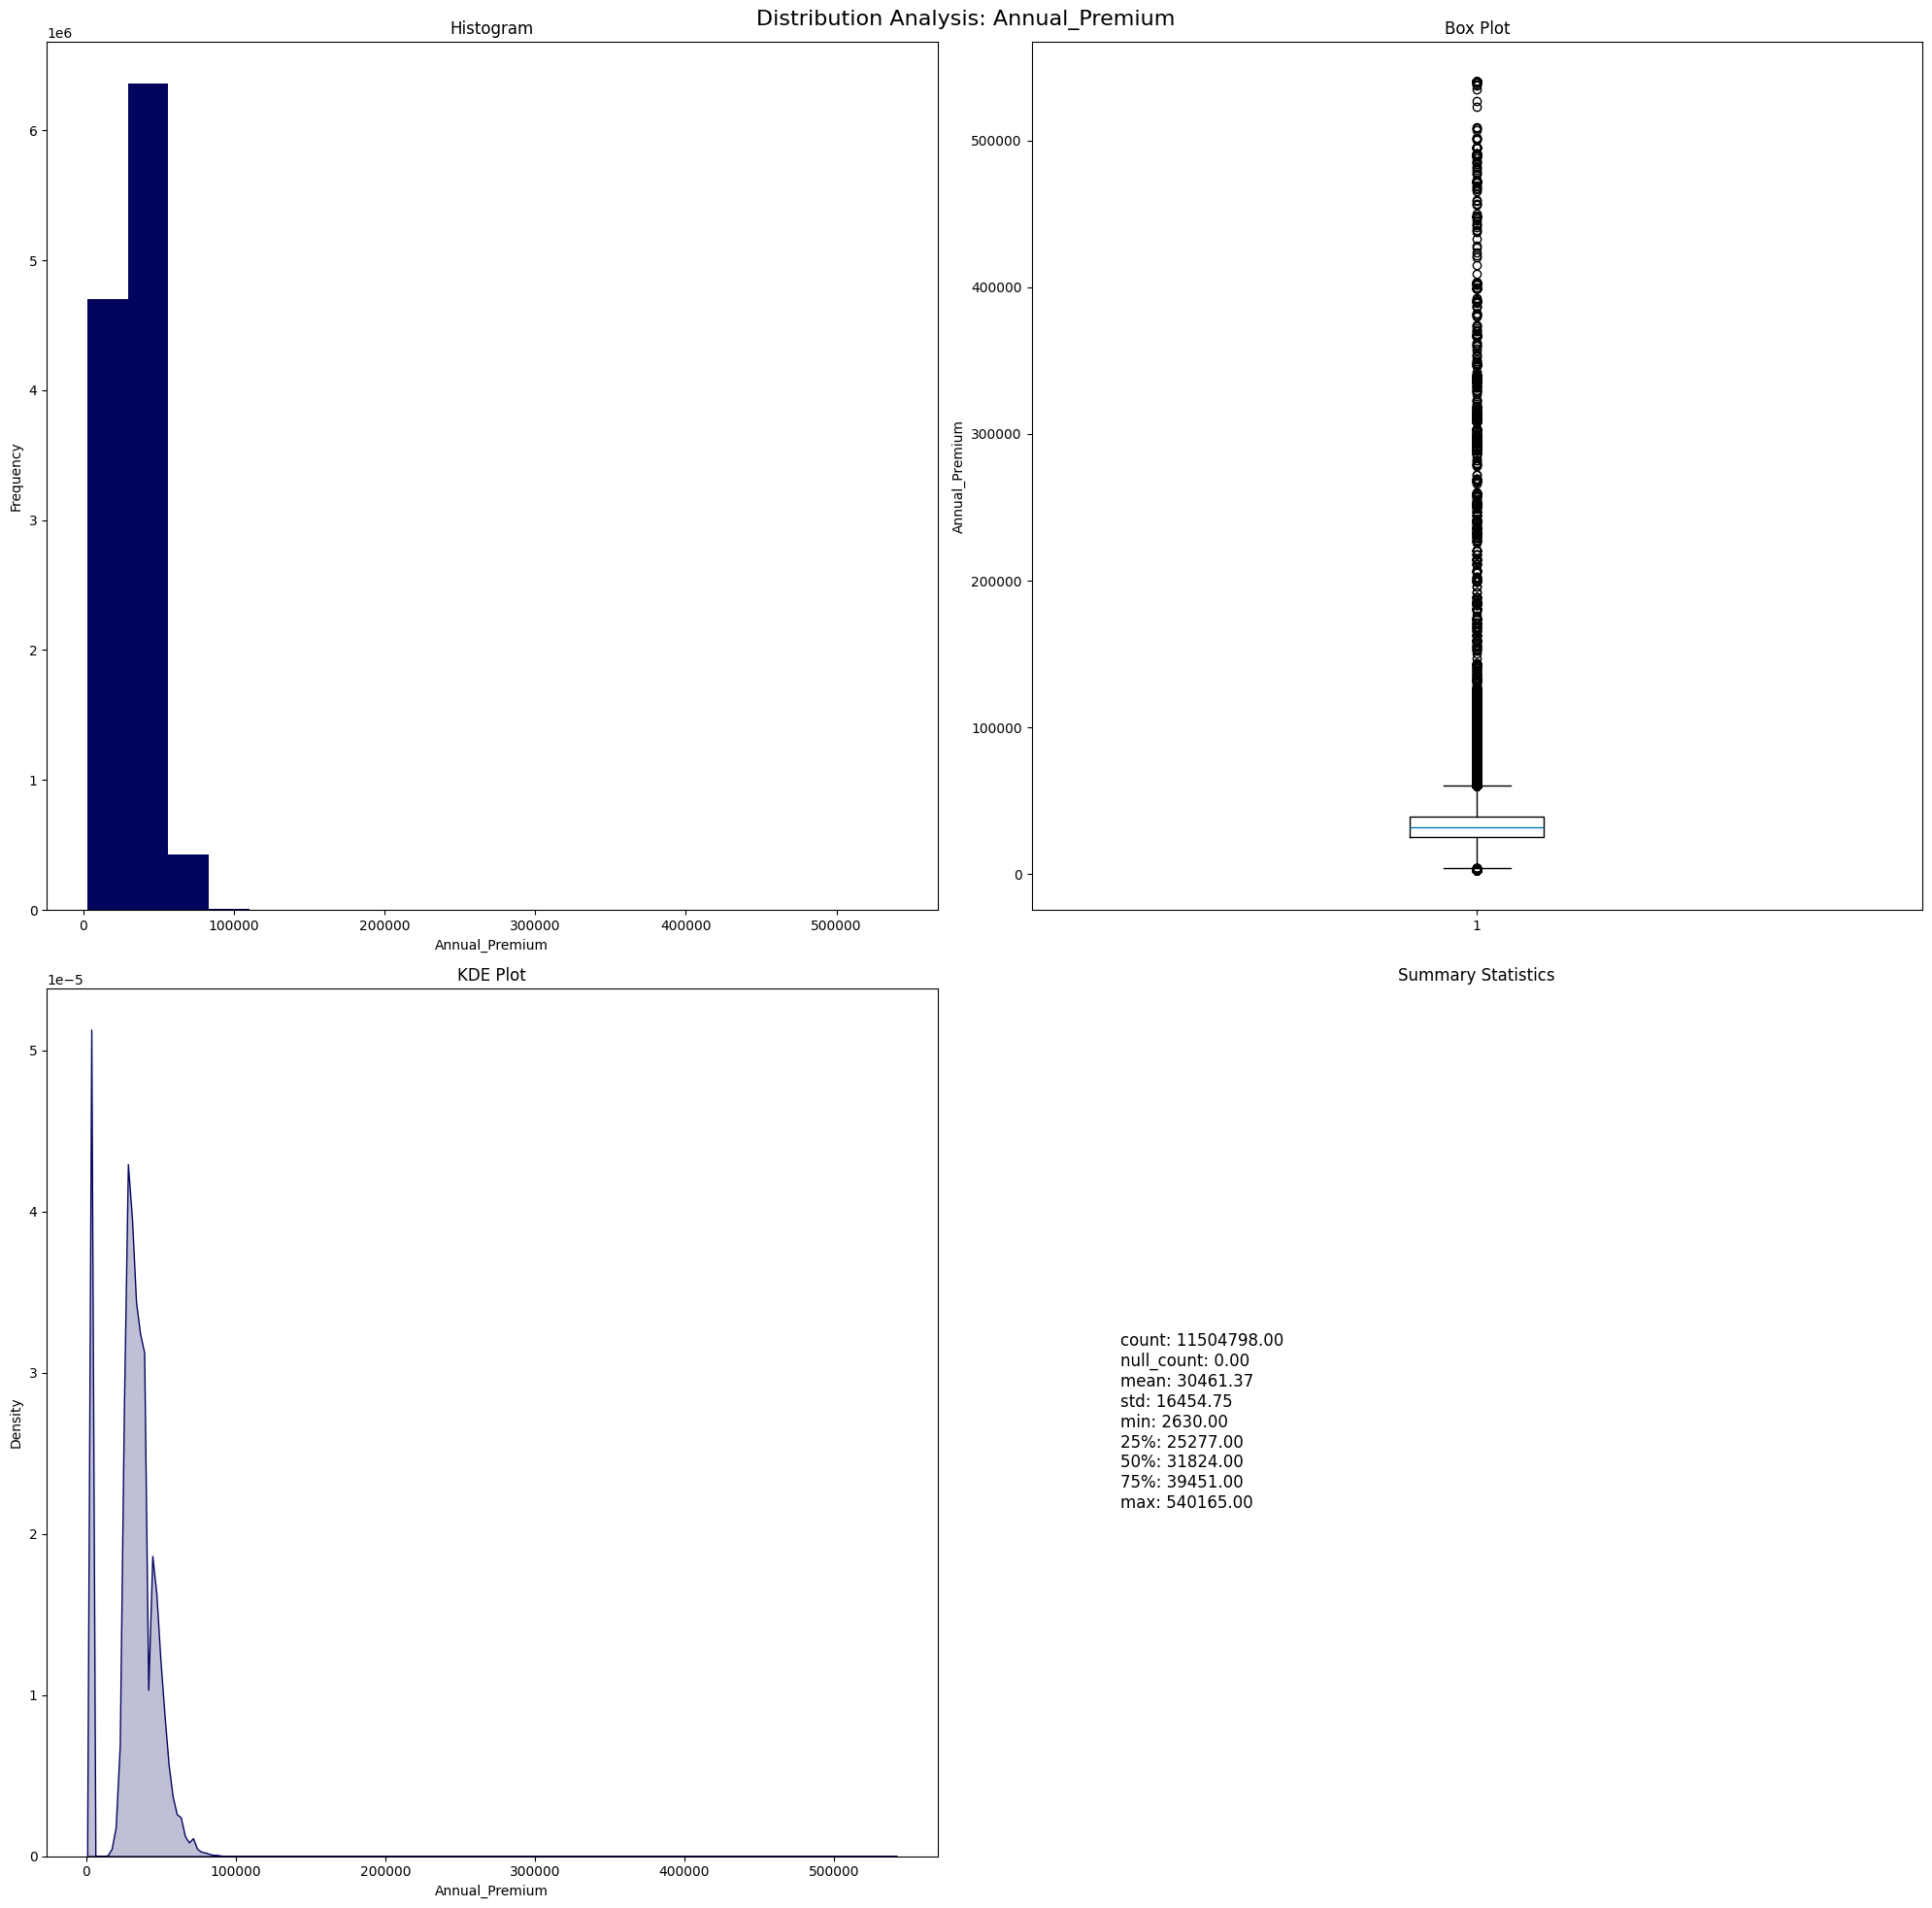

In [14]:
# Displaying general visualizations around the Annual_Premium feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = df['Annual_Premium'])

### Feature 10: `Policy_Sales_Channel`

In [15]:
df['Policy_Sales_Channel'].value_counts()

Policy_Sales_Channel,count
f64,u32
31.0,18144
93.0,414
76.0,33
46.0,152
43.0,20
…,…
106.0,854
89.0,205
37.0,3811


### Feature 11: `Vintage`

In [16]:
df['Vintage'].value_counts()

Vintage,count
i64,u32
23,21070
174,38729
96,48455
108,31671
116,35569
…,…
61,16981
14,20001
141,38562


### Feature 12: `Response`

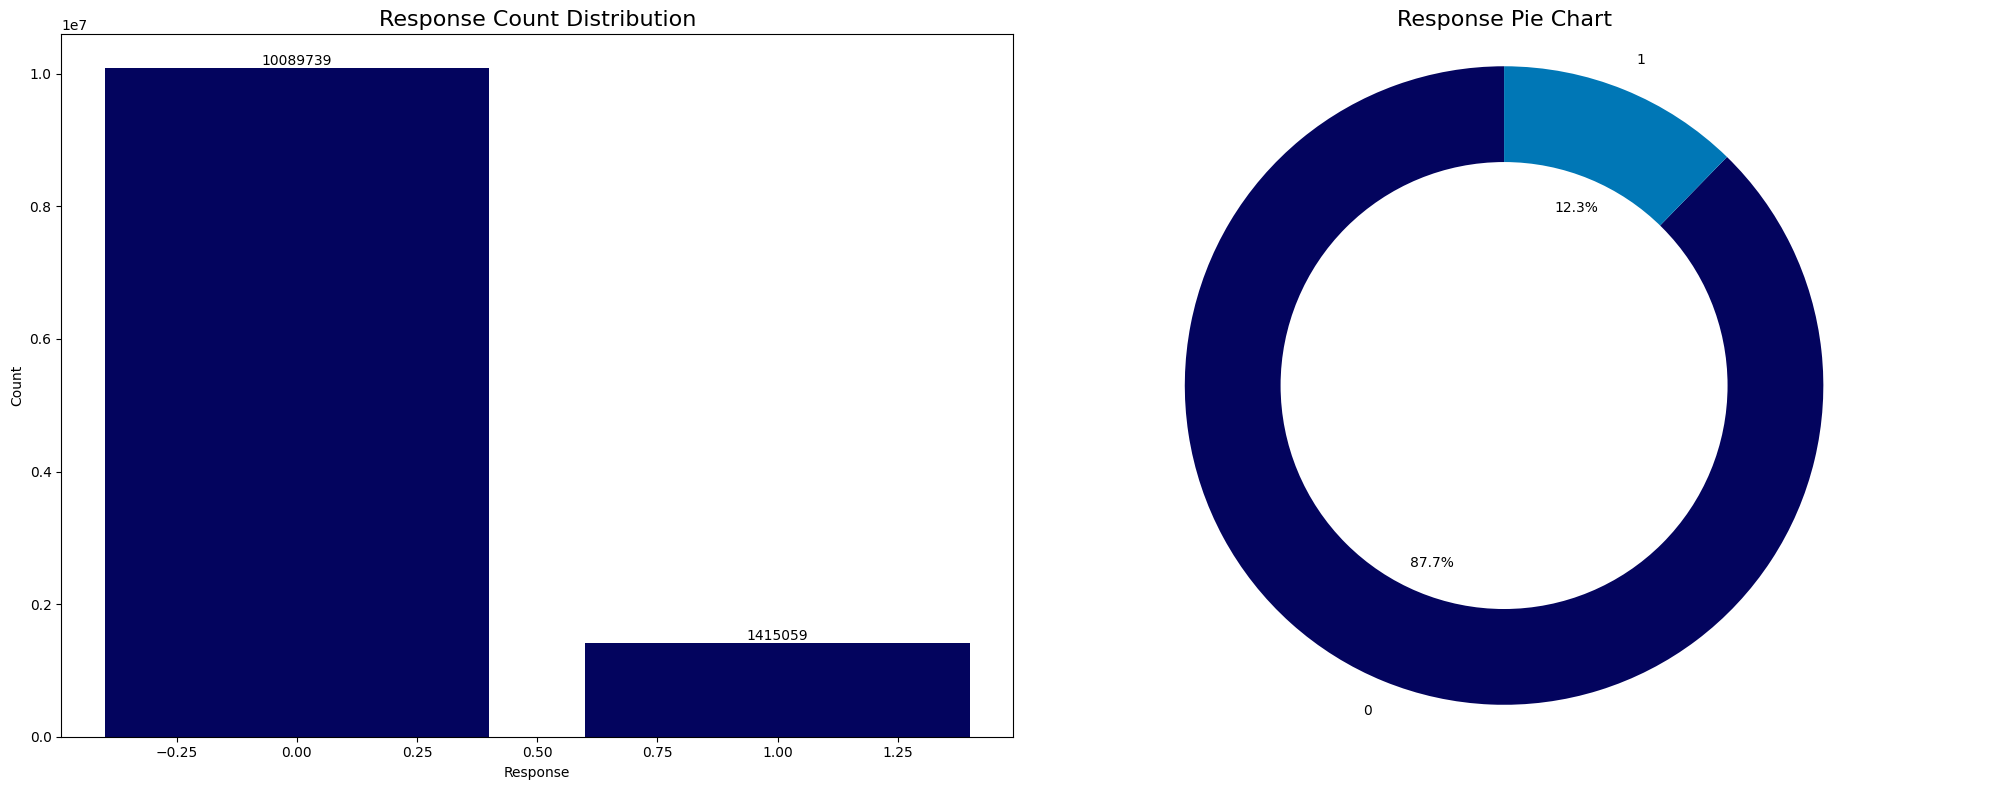

In [17]:
# Displaying general visualizations around the Response feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Response'])

## Feature Engineering